In [19]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
sys.path.append("/Users/ruby/Astro/rlb_LWA")
import dsa2000_sensitivity
import importlib
importlib.reload(dsa2000_sensitivity)
import scipy.integrate

In [2]:
#antlocs_filepath = "/Users/ruby/Astro/20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = 2e9
freq_21cm_hz = c/0.21
#antenna_diameter_m = 5
vis_noise = 1.

In [3]:
antpos = dsa2000_sensitivity.get_antpos()

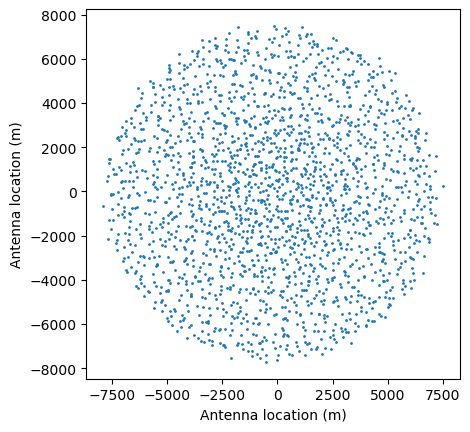

In [4]:
fig, ax = plt.subplots()
ax.scatter(antpos[:,0], antpos[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("Antenna location (m)")
ax.set_ylabel("Antenna location (m)")
plt.show()

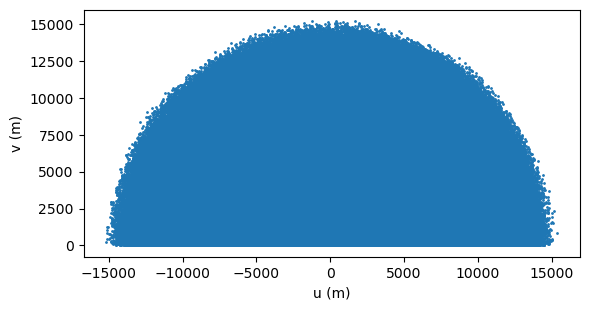

In [5]:
baselines_m = dsa2000_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

In [6]:
uv_plane_variance_arr = np.load("/Users/ruby/Astro/dsa2000_variance.npy")

min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_resolution_hz = 162.5e3
freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)

uv_extent = 1000
field_of_view_deg2 = 10.6
field_of_view_diameter = 2 * np.sqrt(field_of_view_deg2 / np.pi)
uv_spacing = 0.5 * 180 / field_of_view_diameter  # Nyquist sample the FoV
u_coords = np.arange(0, uv_extent, uv_spacing)
u_coords = np.append(-np.flip(u_coords[1:]), u_coords)
v_coords = np.copy(u_coords)

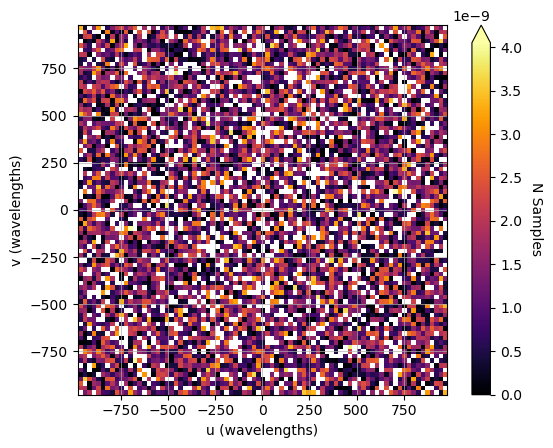

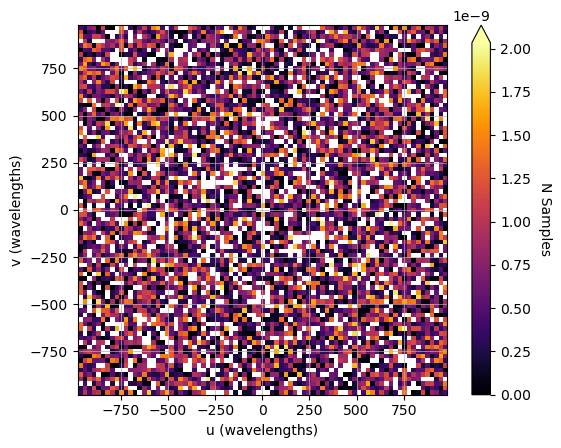

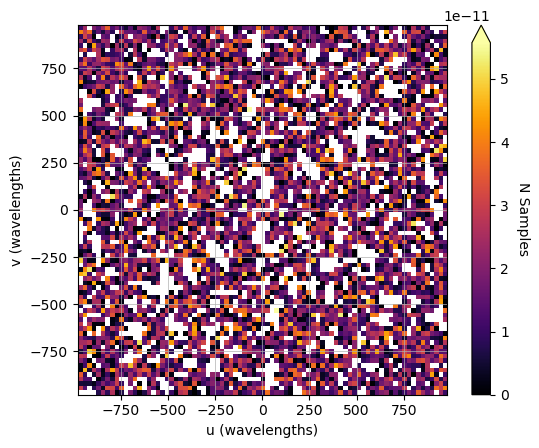

In [7]:
for freq_ind in [0,500,-1]:
    fig, ax = plt.subplots()
    use_cmap = cm.get_cmap("inferno").copy()
    cax = ax.imshow(
        uv_plane_variance_arr[:,:,freq_ind],
        origin="lower",
        interpolation="none",
        extent=[np.min(u_coords), np.max(u_coords), np.min(v_coords), np.max(v_coords)],
        vmin=0,
        cmap=use_cmap,
    )
    ax.set_xlabel("u (wavelengths)")
    ax.set_ylabel("v (wavelengths)")
    ax.grid(linewidth=.5)
    cbar = fig.colorbar(cax, extend="max")
    cbar.set_label("N Samples", rotation=270, labelpad=15)
    plt.show()

In [8]:
np.nanmax(np.abs(uv_plane_variance_arr[:,:,0]-uv_plane_variance_arr[:,:,-1]))

4.014853711547147e-09

In [9]:
where_finite = np.where(np.isfinite(uv_plane_variance_arr))

In [10]:
a = np.nansum(uv_plane_variance_arr, axis=2)

In [11]:
np.shape(a)

(81, 81)

In [12]:
where_finite = np.isfinite(uv_plane_variance_arr)

In [13]:
np.shape(where_finite)

(81, 81, 4484)

In [14]:
np.sum(where_finite, axis=2)

array([[3462, 3836, 4067, ..., 3418, 3340, 3335],
       [3404, 3488, 3676, ..., 3362, 3360, 3483],
       [3218, 3454, 3432, ..., 3404, 3527, 4007],
       ...,
       [4007, 3527, 3404, ..., 3432, 3454, 3218],
       [3483, 3360, 3362, ..., 3676, 3488, 3404],
       [3335, 3340, 3418, ..., 4067, 3836, 3462]])

In [15]:
where_finite = np.isfinite(uv_plane_variance_arr)
uvn_variance = np.nansum(uv_plane_variance_arr, axis=2)/np.sum(where_finite, axis=2)

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_38427/3358941357.py:2: RuntimeWarning: invalid value encountered in true_divide
  uvn_variance = np.nansum(uv_plane_variance_arr, axis=2)/np.sum(where_finite, axis=2)


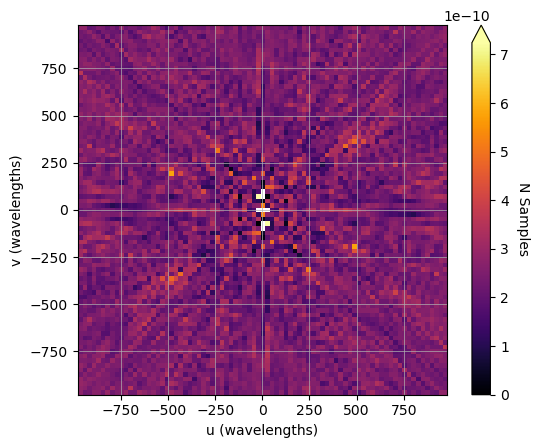

In [16]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    uvn_variance,
    origin="lower",
    interpolation="none",
    extent=[np.min(u_coords), np.max(u_coords), np.min(v_coords), np.max(v_coords)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("N Samples", rotation=270, labelpad=15)
plt.show()

In [17]:
uvn_variance = np.repeat(uvn_variance[:,:,np.newaxis], 1000, axis=2)  # Assume all delays have equal variance

In [18]:
np.shape(uvn_variance)

(81, 81, 1000)

In [21]:
f = lambda x, a: a*x
y, err = scipy.integrate.quad(f, 0, 1, args=(1,))

In [22]:
y

0.5

In [23]:
err

5.551115123125783e-15

In [24]:
hubble_dist = 3000  # Units Mpc/h
hubble_const = c / hubble_dist
rest_frame_wl = 0.21  # Units m
omega_M = 0.27
omega_k = 0
omega_Lambda = 0.73
dc_func = lambda z, omega_M, omega_k, omega_Lambda: 1/np.sqrt(
    omega_M * (1+z)**3. + omega_k*(1+z)**2. + omega_Lambda
)
dc, err = scipy.integrate.quad(dc_func, 0, 7, args=(omega_M, omega_k, omega_Lambda,))

In [25]:
dc

2.088853592441189